In [1]:
import wandb
import pandas as pd
from utils.utils import plot_confidence_error, expected_calibration_error, calculate_macro_ece, calculate_auroc, calculate_auroc
from utils.utils import extract_texts_and_confidences
import re
from utils.utils import compute_exact_match, compute_f1
import math

In [2]:
runs = pd.read_csv("csv/inference.csv")
runs = runs[runs["dataset"] == "HotpotQA"]
runs.reset_index(drop=True, inplace=True)

project_name = "uncertainty-reimplimentation-results"
job_type = "eval-difficulty"

In [3]:
runs["ID"]

0     vy1n12lt
1     uo2u5m33
2     5fdai5h7
3     krk5jsfl
4     2h1uprtd
5     9bwc6w31
6     n4s2lcks
7     eg32i4a1
8     gr7ngjjq
9     62vwtwzf
10    4ozhkaeq
11    27ttbhgo
12    ikkf2ta0
13    kkfqx0eg
14    pjjhsvb9
15    63ulb3ob
Name: ID, dtype: object

vy1n12lt


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lukas-hofbauer (hofbauer) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.73438
auroc,0.79968
ece,0.1676
em,0.50521
f1,0.59138


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.65839
auroc,0.7734
ece,0.23151
em,0.52484
f1,0.60174


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.64815
auroc,0.70242
ece,0.24556
em,0.35802
f1,0.51551


uo2u5m33


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.68912
auroc,0.76435
ece,0.20667
em,0.50259
f1,0.58562


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.64651
auroc,0.75031
ece,0.20663
em,0.51473
f1,0.59303


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.62963
auroc,0.69975
ece,0.1939
em,0.37654
f1,0.53654


5fdai5h7


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.68394
auroc,0.76695
ece,0.13461
em,0.45596
f1,0.54557


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.48217
auroc,0.7802
ece,0.25991
em,0.36279
f1,0.4428


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.53086
auroc,0.73363
ece,0.22315
em,0.29012
f1,0.39563


krk5jsfl


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.68912
auroc,0.76936
ece,0.12228
em,0.48187
f1,0.57546


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.52403
auroc,0.77501
ece,0.21419
em,0.42171
f1,0.49048


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.51235
auroc,0.7267
ece,0.23364
em,0.2963
f1,0.42088


2h1uprtd


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.6943
auroc,0.75904
ece,0.33729
em,0.49223
f1,0.56951


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.64031
auroc,0.75038
ece,0.32146
em,0.51473
f1,0.58894


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.57407
auroc,0.65077
ece,0.26763
em,0.32716
f1,0.47682


9bwc6w31


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.71354
auroc,0.7866
ece,0.15615
em,0.45833
f1,0.55299


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.65781
auroc,0.83159
ece,0.16898
em,0.50625
f1,0.6014


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.54037
auroc,0.81322
ece,0.28261
em,0.30435
f1,0.46229


n4s2lcks


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.6943
auroc,0.79427
ece,0.11399
em,0.47668
f1,0.55452


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.50388
auroc,0.79519
ece,0.22409
em,0.37209
f1,0.45127


wandb:   1 of 1 files downloaded.  
/home/lukas/Documents/Uni/Calibration Paper/code/utils/utils.py:175: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 6))


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.48148
auroc,0.75496
ece,0.27006
em,0.25309
f1,0.35946


eg32i4a1


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.61594
auroc,0.78457
ece,0.2137
em,0.38406
f1,0.46605


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.51807
auroc,0.75587
ece,0.2942
em,0.3821
f1,0.46441


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.5
auroc,0.70573
ece,0.32187
em,0.24306
f1,0.39088


gr7ngjjq


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.76684
auroc,0.72613
ece,0.17475
em,0.53886
f1,0.63884


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.72403
auroc,0.82565
ece,0.1669
em,0.56899
f1,0.65889


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.66667
auroc,0.67524
ece,0.11342
em,0.40123
f1,0.55728


62vwtwzf


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.72021
auroc,0.832
ece,0.16917
em,0.53368
f1,0.63395


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.63411
auroc,0.7728
ece,0.22847
em,0.50388
f1,0.58568


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.58025
auroc,0.74226
ece,0.27988
em,0.33333
f1,0.47041


4ozhkaeq


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.7513
auroc,0.79569
ece,0.17332
em,0.50259
f1,0.6072


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.74068
auroc,0.80966
ece,0.15295
em,0.58851
f1,0.67649


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.68519
auroc,0.70041
ece,0.20309
em,0.38889
f1,0.5688


27ttbhgo


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.76166
auroc,0.76886
ece,0.12565
em,0.54922
f1,0.63785


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.64031
auroc,0.7085
ece,0.2276
em,0.51473
f1,0.59397


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.61111
auroc,0.73224
ece,0.25525
em,0.32716
f1,0.50101


ikkf2ta0


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.64249
auroc,0.74731
ece,0.25622
em,0.41969
f1,0.48969


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.57829
auroc,0.73251
ece,0.31171
em,0.42946
f1,0.5091


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.53704
auroc,0.71954
ece,0.3429
em,0.2963
f1,0.42795


kkfqx0eg


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.66839
auroc,0.7689
ece,0.18342
em,0.43523
f1,0.51954


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.44651
auroc,0.71644
ece,0.38341
em,0.29612
f1,0.38999


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.46296
auroc,0.71241
ece,0.37099
em,0.23457
f1,0.35875


pjjhsvb9


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.6114
auroc,0.75316
ece,0.24637
em,0.40415
f1,0.47377


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.44651
auroc,0.73722
ece,0.4007
em,0.33333
f1,0.40669


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.41975
auroc,0.71214
ece,0.42006
em,0.25926
f1,0.35439


63ulb3ob


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.63731
auroc,0.71667
ece,0.14511
em,0.42487
f1,0.50812


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.55194
auroc,0.79396
ece,0.10007
em,0.42481
f1,0.50616


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
em,▁
f1,▁
macro_ece,▁
acc,0.56173
auroc,0.69161
ece,0.11995
em,0.2963
f1,0.43309


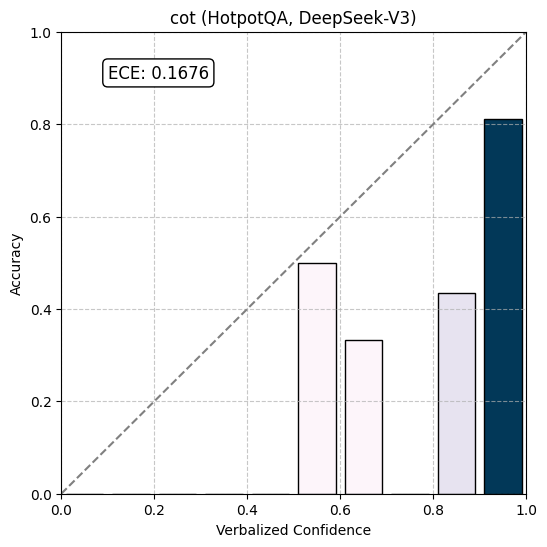

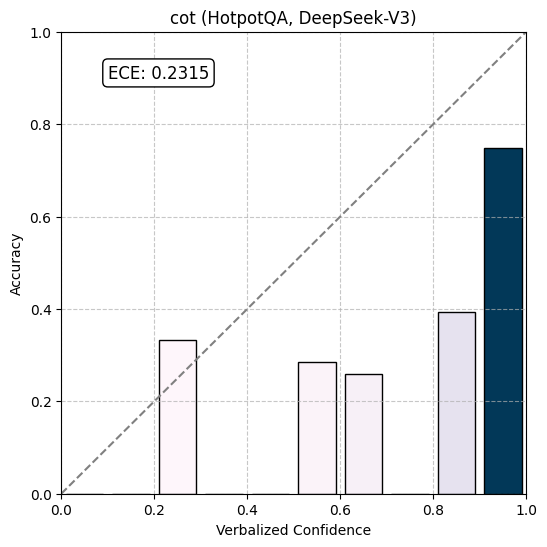

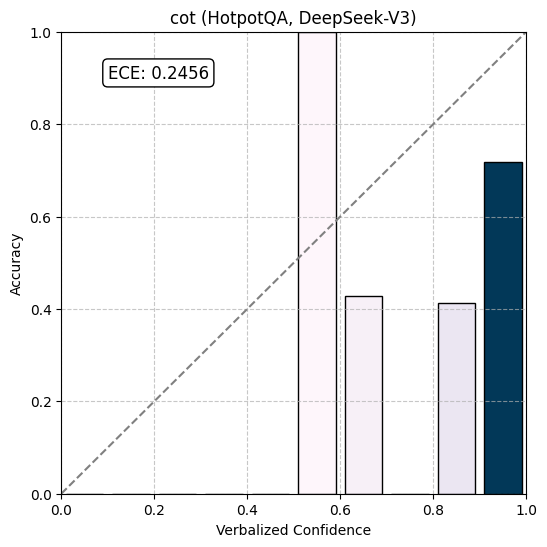

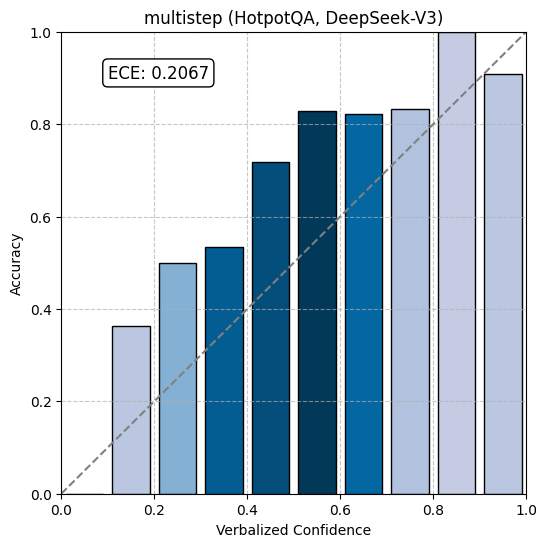

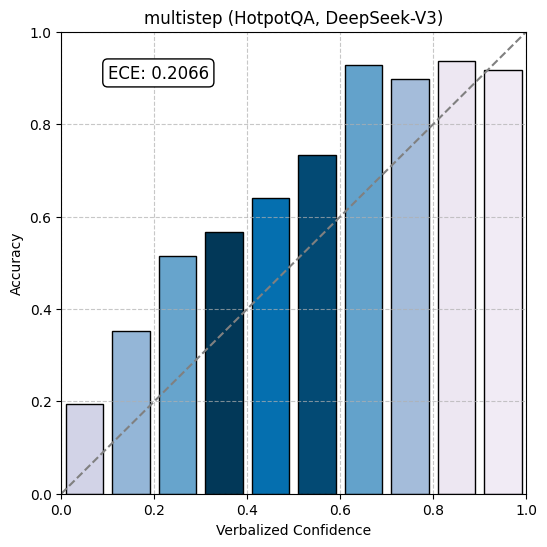

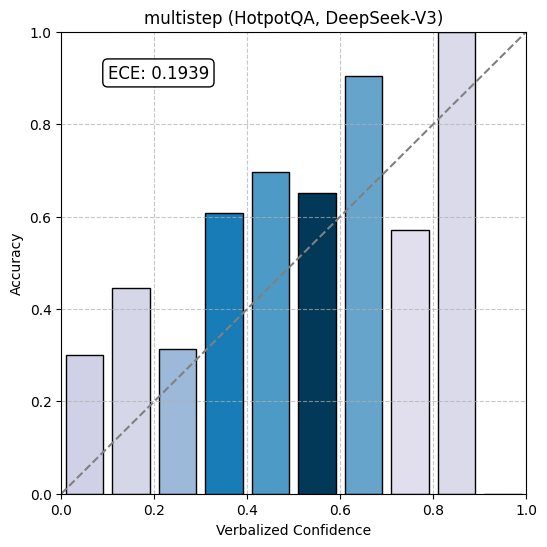

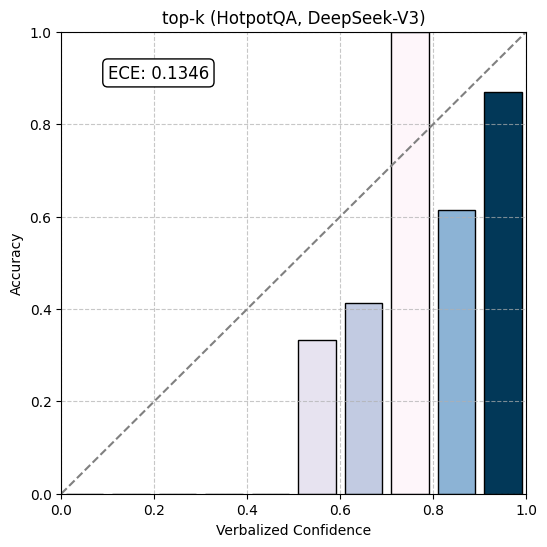

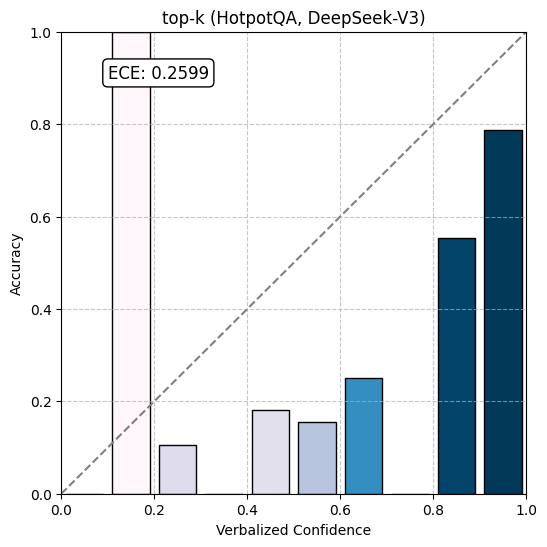

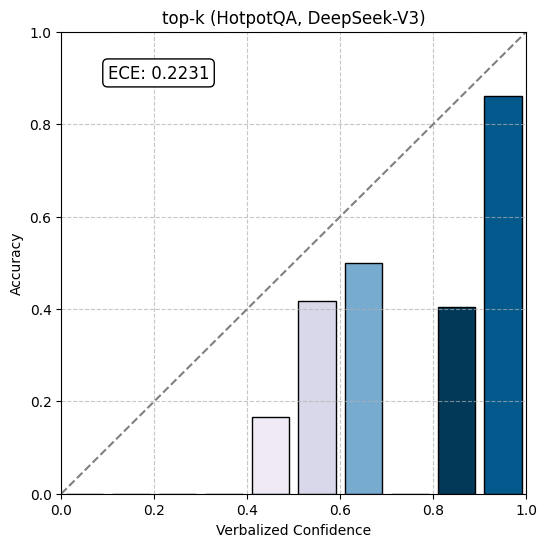

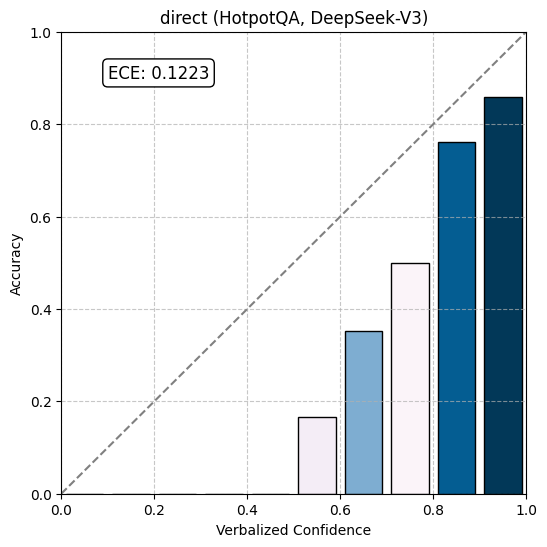

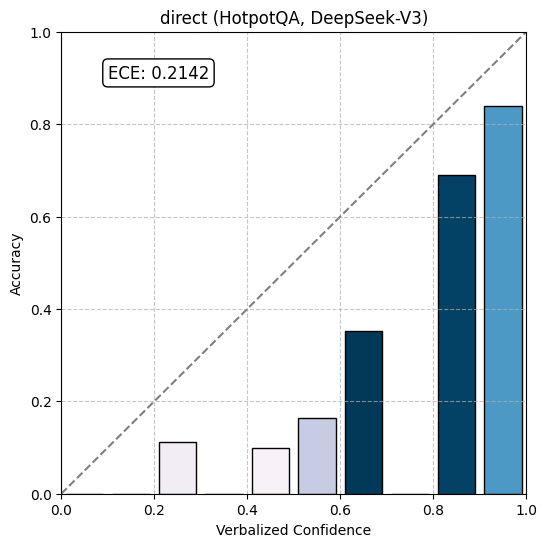

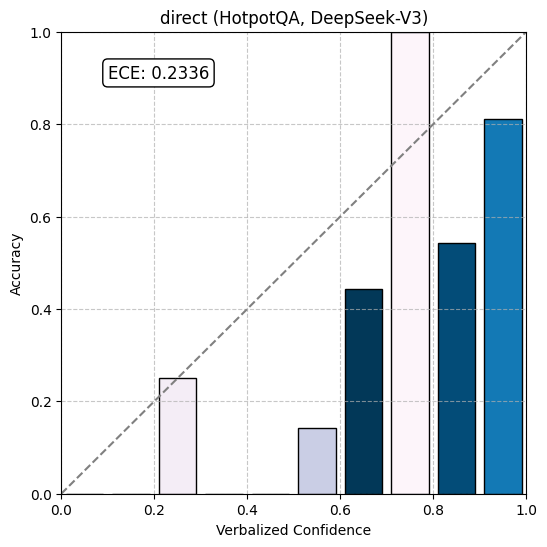

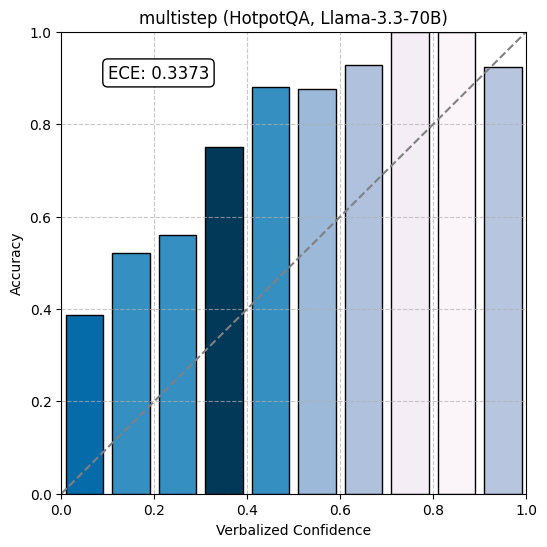

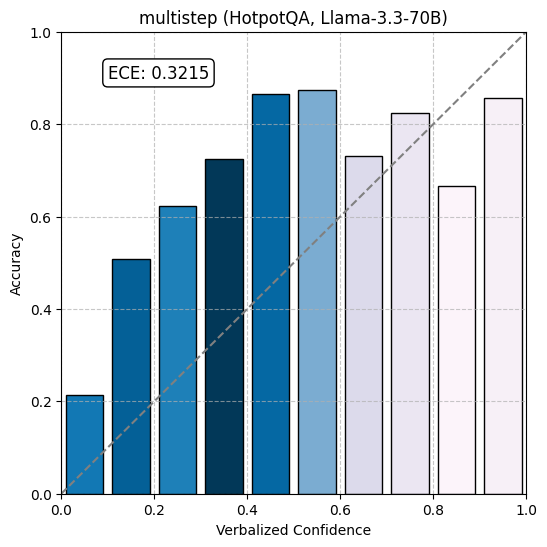

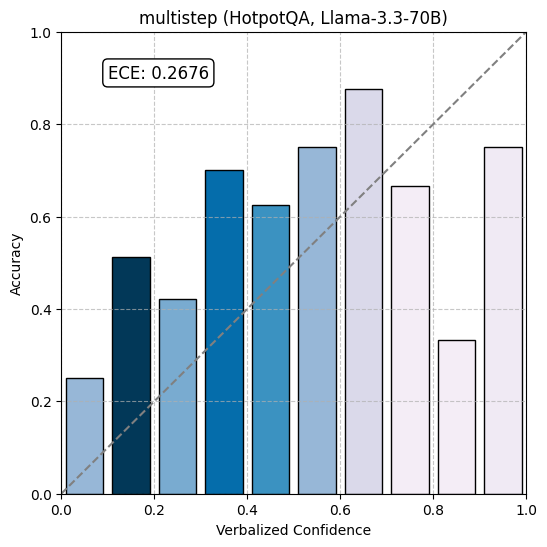

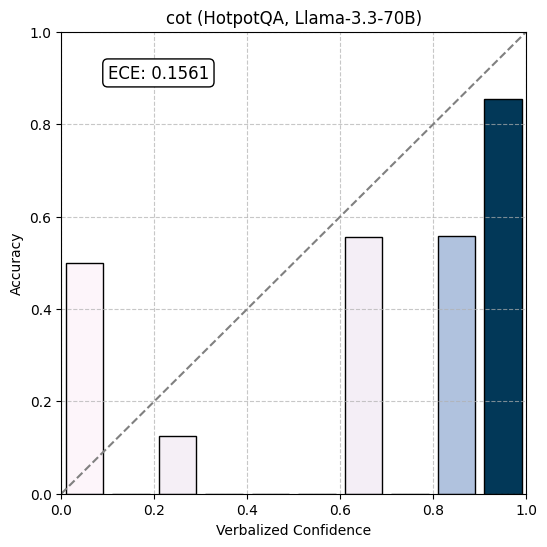

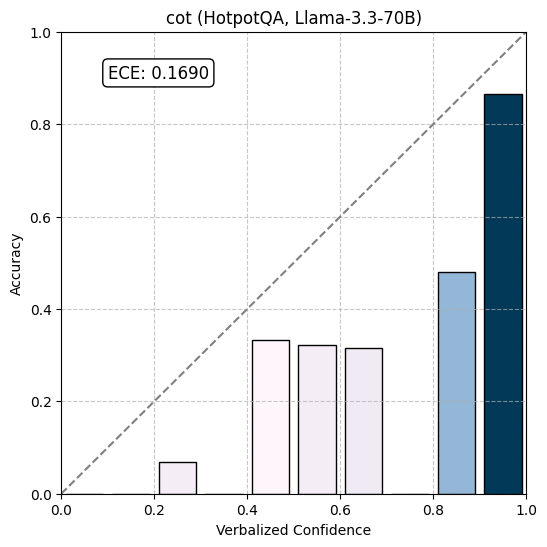

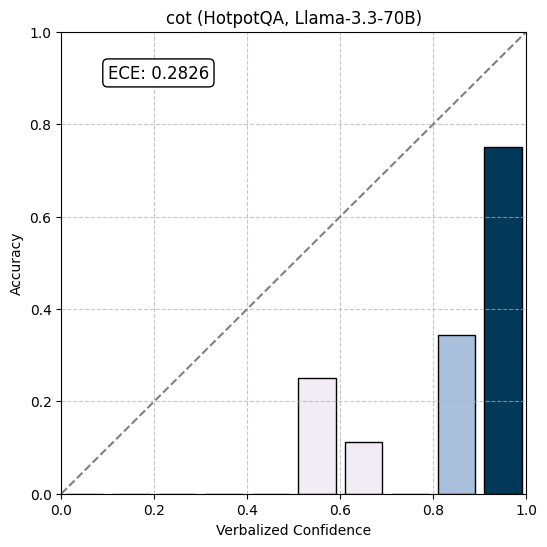

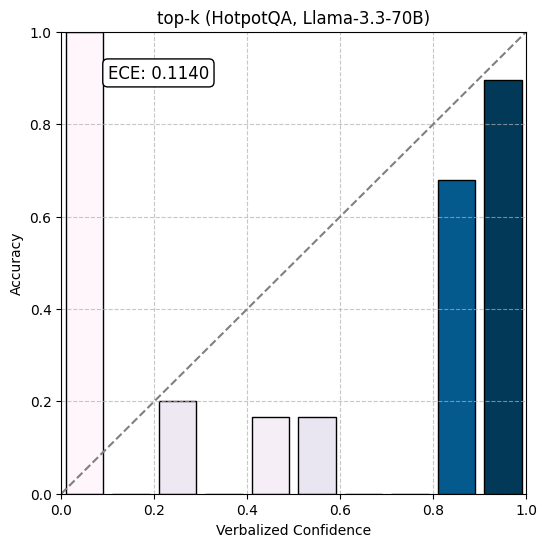

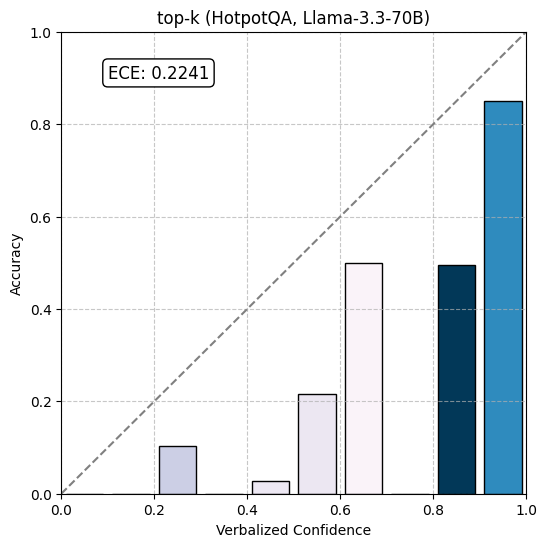

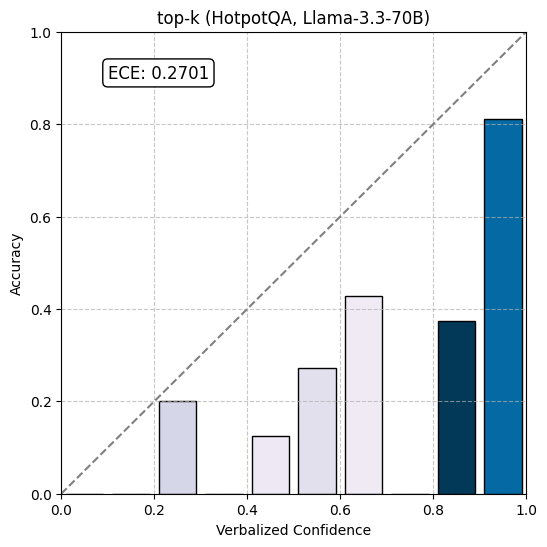

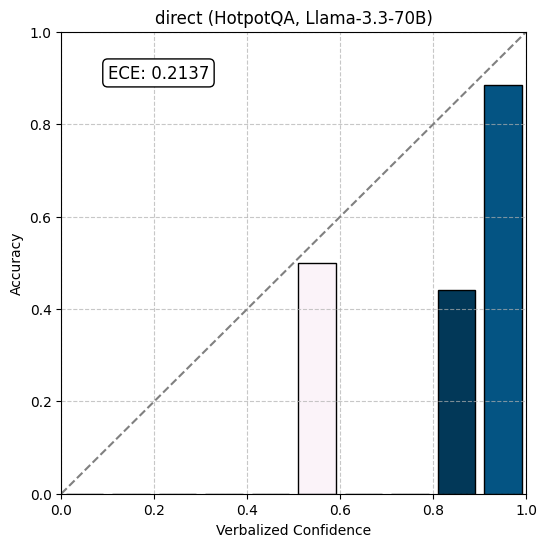

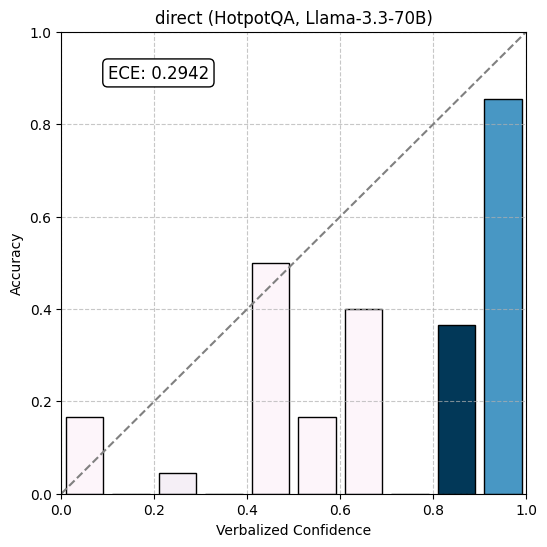

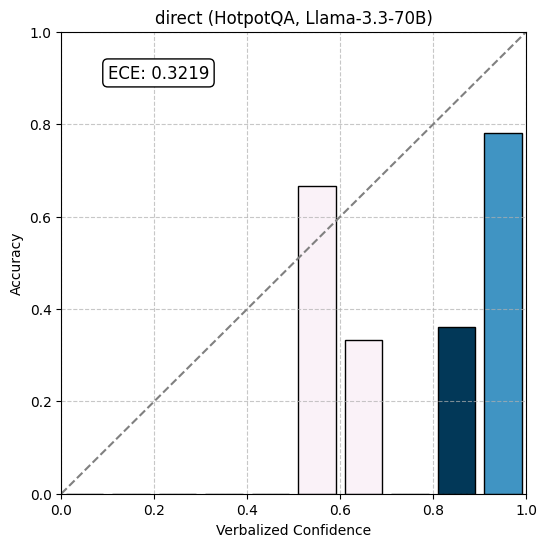

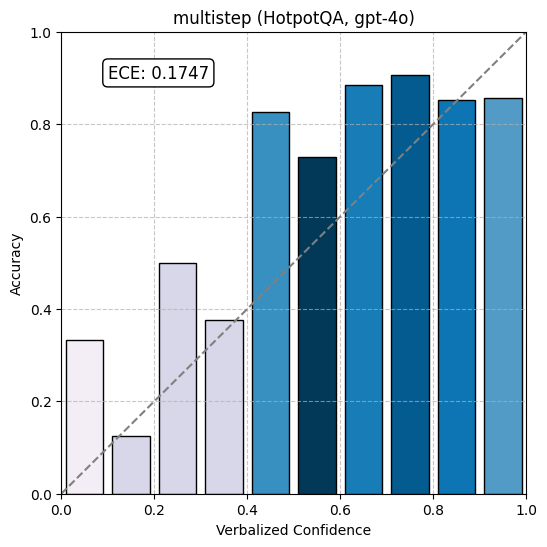

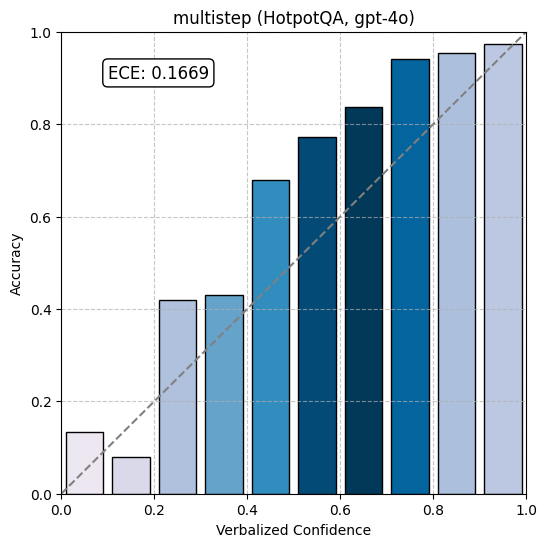

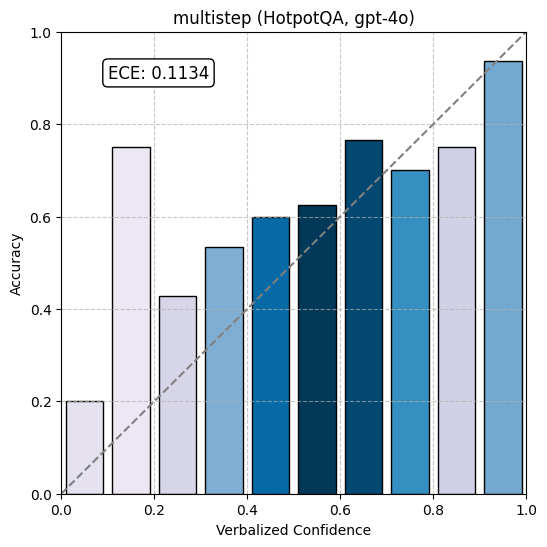

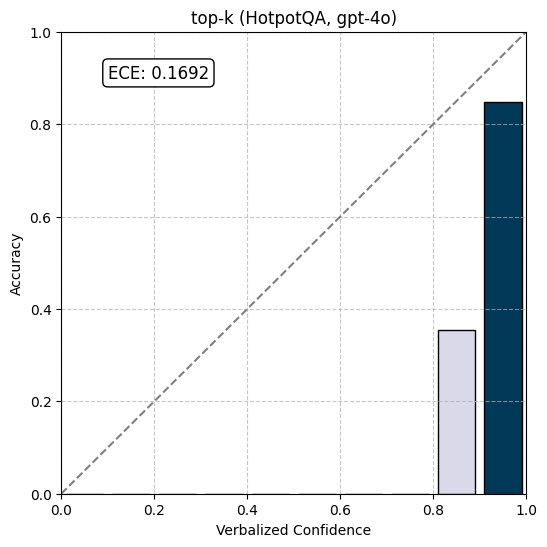

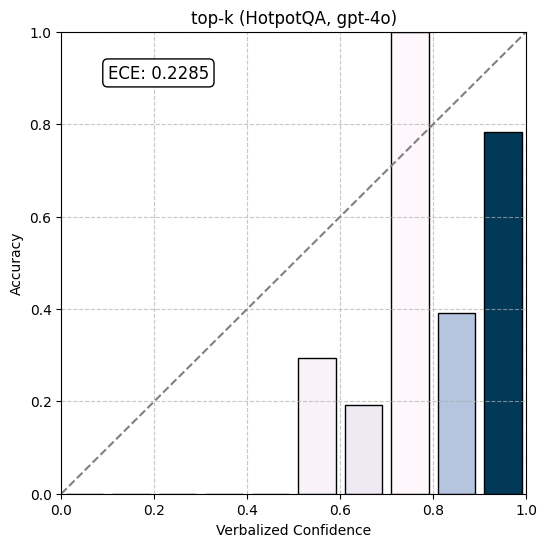

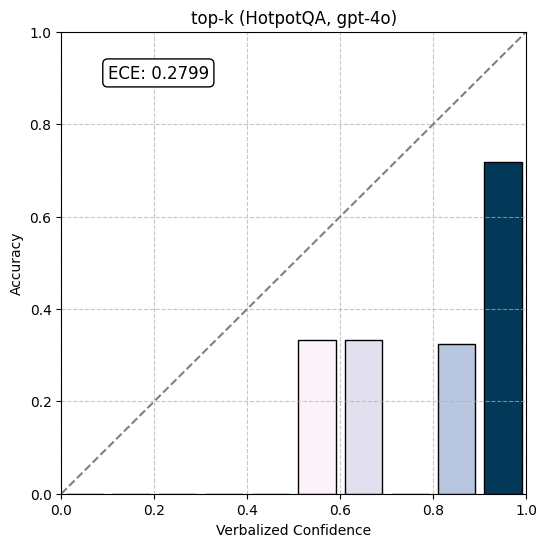

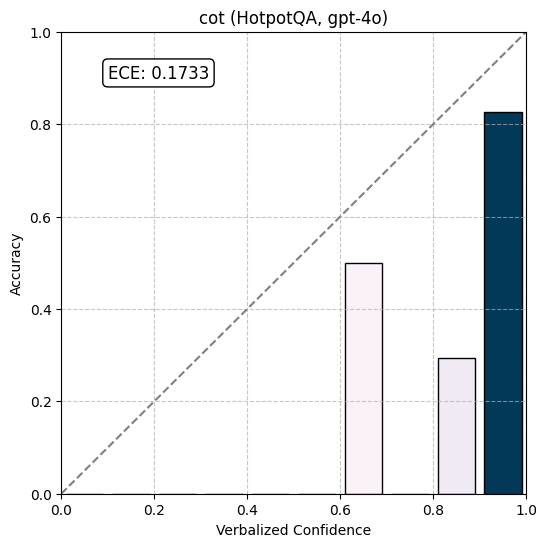

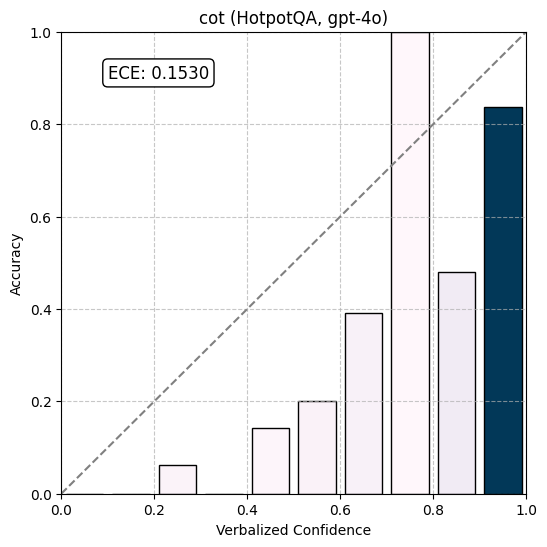

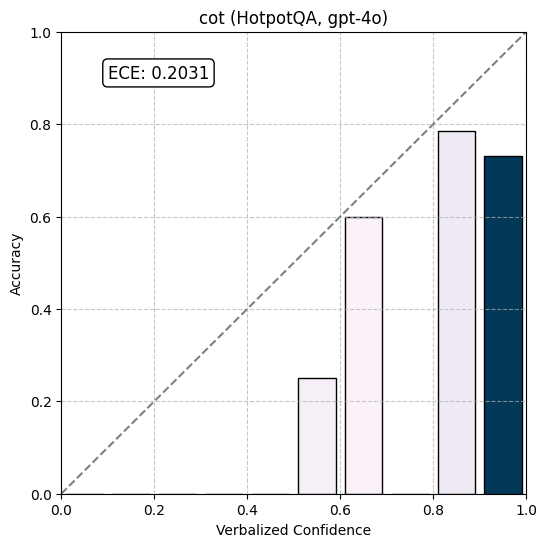

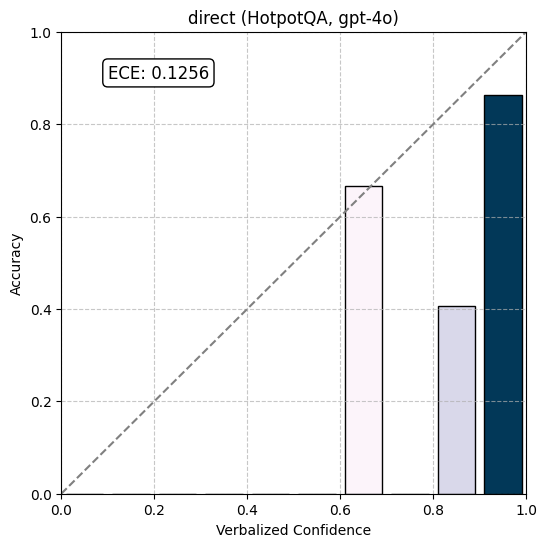

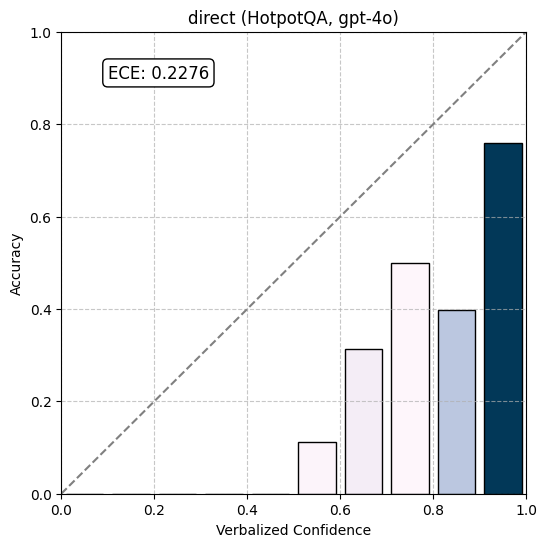

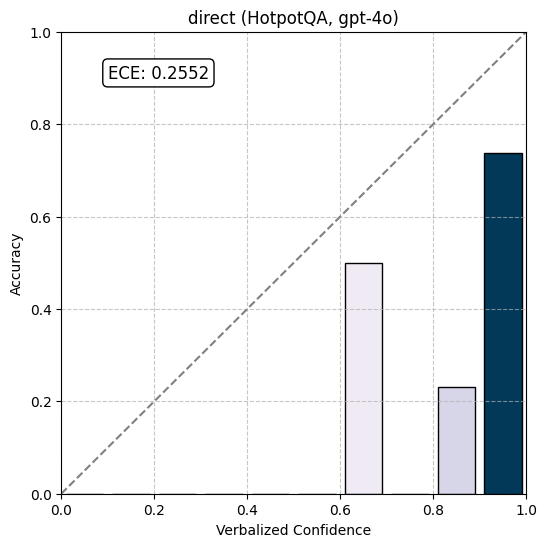

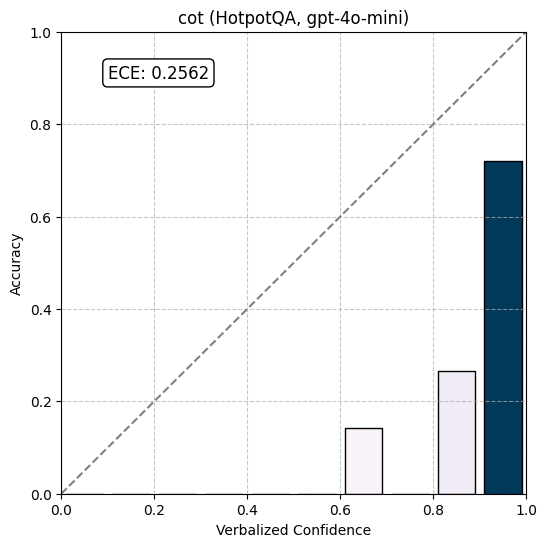

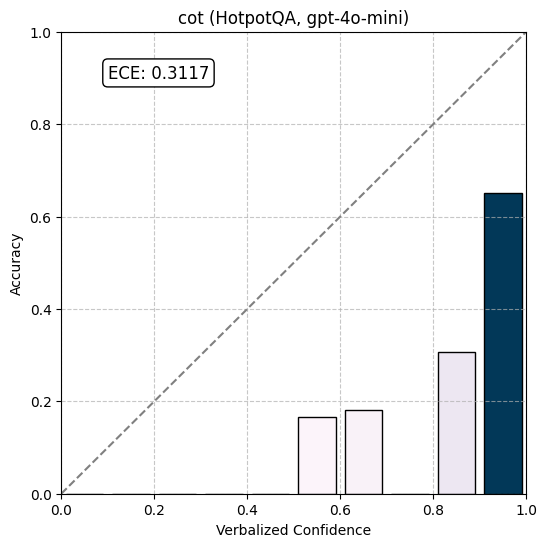

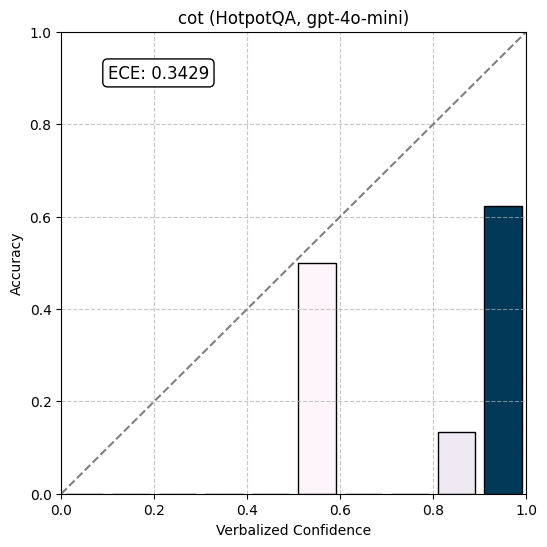

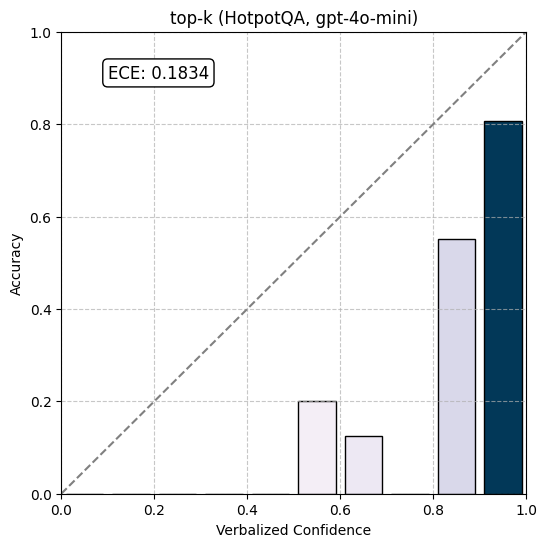

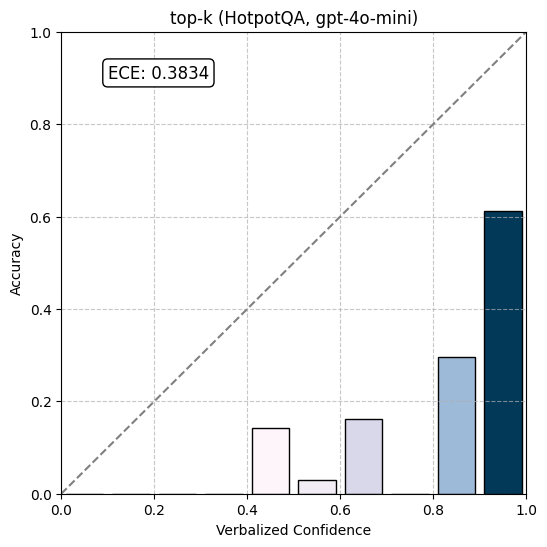

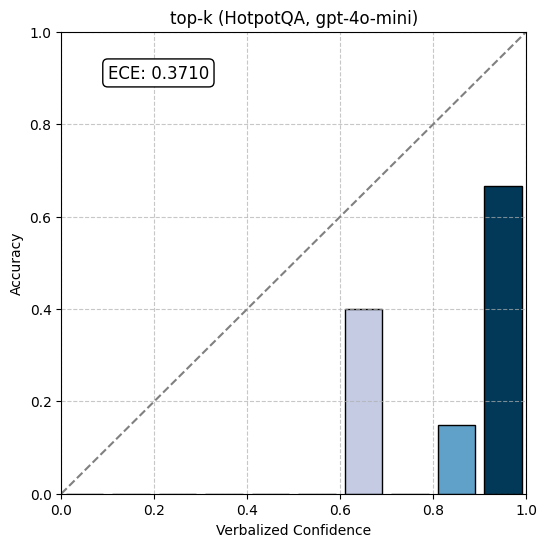

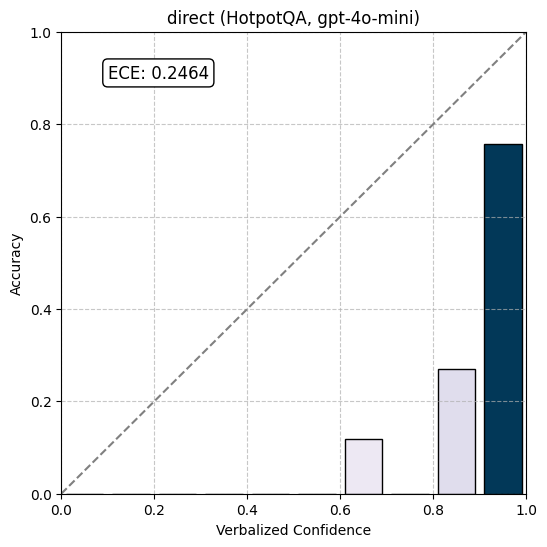

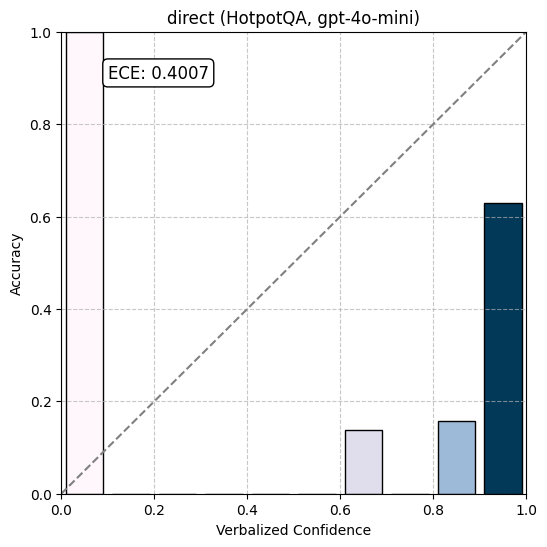

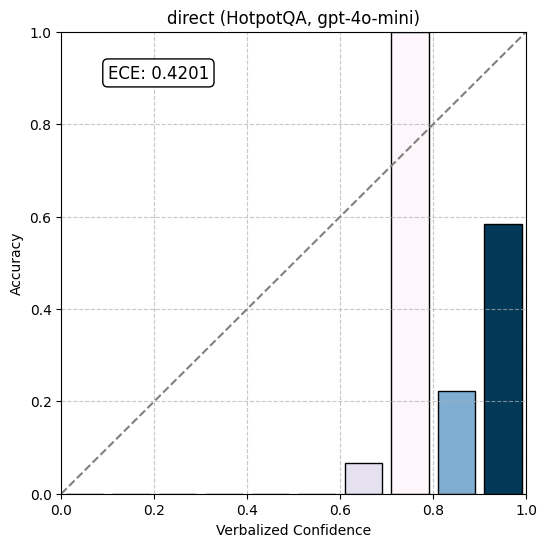

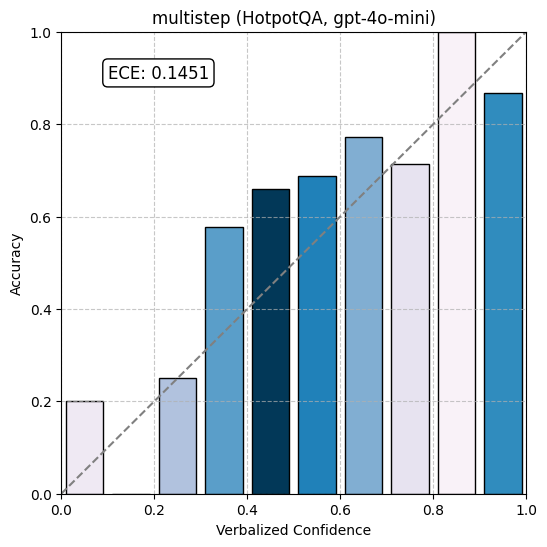

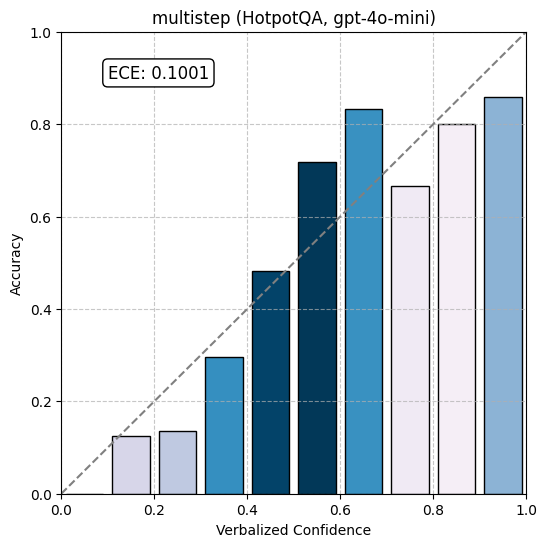

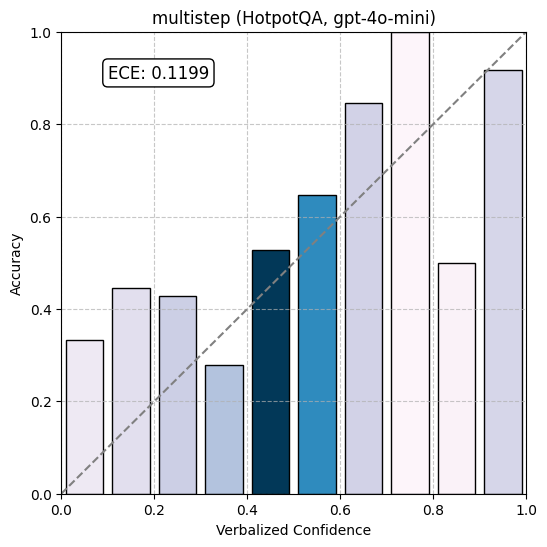

In [4]:
for run_id in runs["ID"]:
    print(run_id)
    for level in ["easy", "medium", "hard"]:
        run = wandb.init(
            project=project_name,
            job_type=job_type,
            config={"difficulty" : level}
        )
        
        table_artifact = run.use_artifact(f"run-{run_id}-table:v0")
        table: pd.DataFrame = table_artifact.get("table").get_dataframe()
        run.config.update(table_artifact.logged_by().config)

        table = table[table["level"] == level]

        fig, _ = plot_confidence_error(
            table["gpt_eval"],
            table["confidence"],
            title=f"{run.config.prompt} ({run.config.dataset}, {run.config.model})",
            ylabel="Accuracy",
            xlabel="Verbalized Confidence",
        )
        
        f1_score = table["f1"].mean()
        em = table["em"].mean()
        accuracy = table["gpt_eval"].mean()
        ece_score = expected_calibration_error(table["gpt_eval"], table["confidence"])
        auroc_score = calculate_auroc(table["gpt_eval"], table["confidence"])
        macro_ece_score = calculate_macro_ece(table, collumn="gpt_eval")
        
        wandb.log(
            {
                "f1": f1_score,
                "em": em,
                "acc": accuracy,
                "ece": ece_score,
                "auroc": auroc_score,
                "macro_ece": macro_ece_score,
            }
        )
        
        wandb.log({"calibration_plot": wandb.Image(fig)})
        wandb.finish()

In [13]:
run.finish()

In [14]:
run = wandb.init(
    project=project_name,
    job_type=job_type,
    config={"aggregation" : aggregation_method}
)

table_artifact = run.use_artifact(f"run-{run_id}-table:v0")
table: pd.DataFrame = table_artifact.get("table").get_dataframe()
run.config.update(table_artifact.logged_by().config)

wandb:   1 of 1 files downloaded.  


In [21]:
table["confidence"] = table["response"].apply(process)
table

,id,question,answer,type,level,response,prediction,confidence,f1,em
0,5ae3cfe05542990afbd1e1e3,"Which airport is located in Maine, Sacramento ...",Knox County Regional Airport,comparison,medium,Step 1: Identify the locations of each airport...,Knox County Regional Airport,1.00,1.000000,1
1,5abc1abf5542993a06baf87f,Peter Hobbs founded the company that is based ...,Failsworth,bridge,medium,Step 1: Identify Peter Hobbs and his company. ...,Altrincham,0.40,0.000000,0
2,5ac250eb5542992f1f2b384f,What direction does the river that Austrolebia...,north to south,bridge,medium,Step 1: Austrolebias bellottii is a species of...,[No specific direction due to temporary habita...,0.60,0.181818,0
3,5a81a60455429903bc27b990,Were both Gabriela Mistral and G. K. Chesterto...,yes,comparison,medium,Step 1: Gabriela Mistral was a Chilean poet an...,yes,0.95,1.000000,1
4,5a70fb2d5542994082a3e482,"What city, other than San Jose del Cabo, is at...",Cabo San Lucas,bridge,medium,Step 1: The Baja California Peninsula is locat...,Cabo San Lucas,1.00,1.000000,1
...,...,...,...,...,...,...,...,...,...,...
995,5a7f8a675542992097ad2f98,"Which school has undergone more name changes, ...",The College of New Jersey,comparison,medium,Step 1: Kettering University was formerly know...,Neither (both have the same number of name cha...,0.70,0.166667,0
996,5a77af405542992a6e59df84,"The 2022 FIFA World Cup will be held in Qatar,...",23rd FIFA World Cup,bridge,easy,Step 1: The 2022 FIFA World Cup is held in Qat...,2026 FIFA World Cup,1.00,0.750000,0
997,5a78b93d55429974737f7863,"What theme park has a land area of 25 ha, whic...",Enchanted Kingdom,bridge,medium,"Step 1: First, identify that 25 ha (hectares) ...",Pandora - The World of Avatar,0.75,0.000000,0
998,5a79098355429970f5fffe2a,"Q: Who is older, Wayne Black or Byron Black?",Byron Black,comparison,medium,Step 1: Wayne Black and Byron Black are both p...,Byron Black,0.80,1.000000,1


In [ ]:
table = pd.concat([table, pd.DataFrame(list(table.apply(process, axis=1)))], axis=1)

table = table.dropna()  ## remove missing rows

fig, _ = plot_confidence_error(
    table["em"],
    table["confidence"],
    title=f"{run.config.prompt} ({run.config.dataset}, {run.config.model})",
    ylabel="Accuracy",
    xlabel="Verbalized Confidence",
)



f1_score = table["f1"].mean()
accuracy = table["em"].mean()
ece_score = expected_calibration_error(table["em"], table["confidence"])
auroc_score = calculate_auroc(table["em"], table["confidence"])
macro_ece_score = calculate_macro_ece(table)

wandb.log(
    {
        "f1": f1_score,
        "acc": accuracy,
        "ece": ece_score,
        "auroc": auroc_score,
        "macro_ece": macro_ece_score,
    }
)

wandb.log({"calibration_plot": wandb.Image(fig)})
wandb.finish()